# Experiment of star graph from size 2 to 39 on ibmq_manhattan, with measurement error mitigation proposed by Bravyi et al.

External packages by my own:
- bell_ineq.py \
importing the inequality by Baccari et al.

- graph_lib.py \
importing graph library such as making adjacency list of star graph

- graph_state_lib.py \
importing the circuit preparation functions for graph states

## import libraries

### import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
import pickle
import pprint
import time

In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import qiskit.ignis.mitigation as mit
import qiskit.quantum_info as qi
# from qiskit.ignis.mitigation.measurement import complete_meas_cal, tensored_meas_cal, CompleteMeasFitter, TensoredMeasFitter

### import original library

In [3]:
import importlib
import star_bell_ineq
importlib.reload(star_bell_ineq)
from star_bell_ineq import *
import graph_lib
from graph_lib import *
import graph_state_lib
from graph_state_lib import *

### load account

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
print(provider)

<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>


## create star graph information from size 2 to 39
we test the size from 2 to 39

change the number of 27 of "max_size = len(vertex_list[:27]) # largest graph size" if you want to try up to other size

In [5]:
vertex_list =  [19, 
                25, 
                20, 33,
                18, 21, 32,
                34, 17, 12, 31,
                22, 35, 16, 8, 39, 
                11, 30, 23, 36, 15, 7, 45,
                40, 9, 4, 29, 26, 37, 24, 6, 46,
                14, 44, 49, 3, 28, 5, 47] # qubit layout
max_size = len(vertex_list) # largest graph size
Fs = [[0] for n in range(1, max_size + 1)] # subsets of focused vertices of graph size 1 to max_size
adj_lists = [adjacency_list_for_star_graph(n) for n in range(1, max_size + 1)] # adjacency list of graph size 1 to max_size
graphs = [list_to_matrix(adj_list) for adj_list in adj_lists] # adjacency matrix of graph size 1 to max_size
shots_per_circuit = 1 << 13 # shots per one execution
graph_sizes = [len(adj_list) for adj_list in adj_lists]
system_size = len(vertex_list)

In [6]:
print("max_size:", max_size)
print("system_size:", system_size)
print("shots_per_circuit:", shots_per_circuit)
print("graph_sizes:", graph_sizes)

max_size: 39
system_size: 39
shots_per_circuit: 8192
graph_sizes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [7]:
# indicate how to connect qubits
order = [[0,1],
         [0,2],[1,3],
         [0,4],[2,5],[3,6],
         [3,7],[4,8],[5,9],[6,10],
         [5,11],[7,12],[8,13],[9,14],[10,15],
         [8,16],[10,17],[11,18],[12,19],[13,20],[14,21],[15,22],
         [12,23],[14,24],[16,25],[17,26],[18,27],[19,28],[20,29],[21,30],[22,31],
         [20,32],[22,33],[23,34],[25,35],[26,36],[30,37],[31,38]]

In [8]:
qubit_depths = [0, 
                1, 
                2, 2,
                3, 3, 3, 
                4, 4, 4, 4, 
                5, 5, 5, 5, 5, 
                6, 6, 6, 6, 6, 6, 6, 
                7, 7, 7, 7, 7, 7, 7, 7, 7,
                8, 8, 8, 8, 8, 8, 8]
print(qubit_depths)
print(len(qubit_depths))

[0, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8]
39


## prepare quantum circuits (from size 2 to 39)

In [9]:
qcs = [refocusing_last_star_graph_state(size, order[:size-1], qubit_depths[:size], system_size) for size in range(1, max_size+1)]
qcs_list, nums_divide_list, nums_meas_cal_list, metadatas_list, _, initial_layouts_list = \
    prepare_grouping_star_graph_qcs_list(qcs, 
                                        adj_lists, 
                                        measure_last=True,
                                        optimization_level=0,
                                        initial_layouts=[vertex_list[:system_size]] * len(qcs),
                                        method="CTMP",
                                        mitigation_limit=15)
print("the number of graph state circuits is: ", len(qcs_list))

the number of graph state circuits is:  223


In [10]:
ops_qcs_list = [qc.count_ops() for qc in qcs_list]
print(len(qcs_list), "quantum circuits")
print("length of initial_layouts_list: ", len(initial_layouts_list))

223 quantum circuits
length of initial_layouts_list:  223


In [11]:
qcs_depths = [qc.depth() for qc in qcs[1:]]
print("qcs_depth:", qcs_depths)

qcs_depth: [4, 5, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11]


## cast jobs to ibmq_manhattan and save job ids

In [12]:
device = provider.backends.ibmq_manhattan
backend = provider.get_backend('ibmq_manhattan')

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  """Entry point for launching an IPython kernel.


In [13]:
"""
jobs = execute_circuits(qcs_list,
                        backend='ibmq_manhattan', 
                        provider=provider, 
                        shots=shots_per_circuit,
                        max_experiments=900,
                        optimization_level=1,
                        initial_layout=initial_layouts_list)
print(len(jobs), "jobs")
"""

'\njobs = execute_circuits(qcs_list,\n                        backend=\'ibmq_manhattan\', \n                        provider=provider, \n                        shots=shots_per_circuit,\n                        max_experiments=900,\n                        optimization_level=1,\n                        initial_layout=initial_layouts_list)\nprint(len(jobs), "jobs")\n'

In [14]:
job_ids_filename = "job_ids_manhattan_star.pkl"

In [15]:
# with open(job_ids_filename, "wb") as f:
#     pickle.dump([job.job_id() for job in jobs], f)

In [16]:
# with open("manhattan_properties_star.pkl", "wb") as f:
#     pickle.dump(device.properties(), f)

## retrieve jobs

In [17]:
with open(job_ids_filename, "rb") as f:
     job_ids = pickle.load(f)

In [18]:
# using job_ids_to_result function
results_jobs_list = job_ids_to_result(job_ids, device)
print(len(results_jobs_list))

1


## measurement error mitigation (CTMP)

In [19]:
results_list = flatten_results_jobs_list(results_jobs_list)
print("length of results_list: ", len(results_list))
del results_jobs_list

length of results_list:  223


In [20]:
def arrange_results_list_for_grouping_star_graph(results_list, nums_divide_list, nums_meas_cal_list, limit=100):
    pos = 0
    results_graph_states = []
    results_meas_cal = []
    for i, (nums_divide, nums_meas_cal) in enumerate(zip(nums_divide_list, nums_meas_cal_list)): # graph wise
        for num_divide in nums_divide: # term wise
            results_graph_states += results_list[pos:pos + num_divide]
            pos += num_divide
        if i < limit: # start from 2
            for num_meas_cal in nums_meas_cal: # term wise
                results_meas_cal.append(merge_results(results_list[pos:pos + num_meas_cal]))
                pos += num_meas_cal
    return results_graph_states, results_meas_cal

In [21]:
results_graph_states, results_meas_cal = arrange_results_list_for_grouping_star_graph(results_list, nums_divide_list, nums_meas_cal_list, limit=15)
print("length of results_graph_states: ", len(results_graph_states))
print("length of results_meas_cal: ", len(results_meas_cal))
print("length of results_metadata_list: ", len(metadatas_list))
del results_list

length of results_graph_states:  76
length of results_meas_cal:  14
length of results_metadata_list:  38


In [22]:
# meas_mitigator_list = prepare_meas_mitigator_list(results_meas_cal, metadatas_list[:14])
# print("length of meas_mitigator_list: ", len(meas_mitigator_list))

In [23]:
counts_dict_list = results_list_to_counts_dict_list(results_graph_states)
print("length of counts_dict_list: ", len(counts_dict_list))

length of counts_dict_list:  76


### Tensored

In [24]:
def arrange_results_list_tensored(results_list, nums_divide_list, nums_meas_cal_list, limit=100):
    pos = 0
    results_graph_states = []
    results_meas_cal = []
    for i, (nums_divide, nums_meas_cal) in enumerate(zip(nums_divide_list, nums_meas_cal_list)): # graph wise
        for num_divide in nums_divide: # term wise
            results_graph_states += results_list[pos:pos + num_divide]
            pos += num_divide
        if i < limit: # start from 2
            for num_meas_cal in nums_meas_cal: # term wise
                results_meas_cal.append(merge_results(results_list[pos:pos + 2]))
                pos += num_meas_cal
    return results_graph_states, results_meas_cal

In [25]:
with open(job_ids_filename, "rb") as f:
     job_ids = pickle.load(f)
results_jobs_list = job_ids_to_result(job_ids, device)
print(len(results_jobs_list))
results_list = flatten_results_jobs_list(results_jobs_list)
print("length of results_list: ", len(results_list))
del results_jobs_list
_, results_meas_cal = arrange_results_list_tensored(results_list, nums_divide_list, nums_meas_cal_list, limit=15)
print("length of results_meas_cal: ", len(results_meas_cal))
del results_list

1
length of results_list:  223
length of results_meas_cal:  14


In [26]:
tensored_meas_mitigator_list = []
for n in range(2,16):
    qr = qiskit.QuantumRegister(n)
    mit_pattern = [[i] for i in range(n)]
    tensored_meas_mitigator_list.append( TensoredMeasFitter(results_meas_cal[n - 2], mit_pattern=mit_pattern).filter )
del results_meas_cal

## compute correlation

In [27]:
# without CTMP mitigation
corr_list_real, stddev_list_real, Es_list_real, Ds_list_real = analyze_circuits_for_star_graph(adj_lists,
                                                                                            counts_dict_list,
                                                                                            None)

graph size: 1
skipped

graph size: 2
total correlation: 2.611599459421409 

graph size: 3
total correlation: 5.006716520501039 

graph size: 4
total correlation: 6.98889426991118 

graph size: 5
total correlation: 7.239903366553084 

graph size: 6
total correlation: 9.498985236330222 

graph size: 7
total correlation: 11.859920866092729 

graph size: 8
total correlation: 9.1872091506801 

graph size: 9
total correlation: 10.365260096680345 

graph size: 10
total correlation: 7.209865139031976 

graph size: 11
total correlation: 10.136002819967517 

graph size: 12
total correlation: 16.183008760251305 

graph size: 13
total correlation: 16.9591689380381 

graph size: 14
total correlation: -4.371080004795748 

graph size: 15
total correlation: 14.152148366237988 

graph size: 16
total correlation: 16.552099165079635 

graph size: 17
total correlation: 14.725636825003054 

graph size: 18
total correlation: 17.460841864338907 

graph size: 19
total correlation: 16.256205360647566 

graph s

In [28]:
def analyze_circuits_tensored(adj_lists, counts_dict_list, tensored_meas_mitigator_list=None, limit=100, method='fast', threshold=0.1):
    """
    Input
        adj_lists         : list of adjacency list
        counts_list       : list of int list (list of counts)
        meas_mitigator : measurement mitigator
    Output
        expval_all_list : list of float (correlation of each graph)
        stddev_all_list : list of float (standard deviation of each graph)
        Es_all_list   : list of list (term-wise correlation of each graph)
        Ds_all_list   : list of list (term-wise stddev of each graph)
    """
    expval_all_list, stddev_all_list, Es_all_list, Ds_all_list = [], [], [], []
    # begin = 0
    for adj_list in adj_lists:
        t1 = time.time()
        n = len(adj_list)
        if n > limit:
            break
        print("graph size:", n)
        if n <= 1:
            print("skipped\n")
            expval_all_list.append(0)
            stddev_all_list.append(0)
            Es_all_list.append([])
            Ds_all_list.append([])
            continue

        # for the first term
        print("first term")
        print(counts_dict_list[2 * (n - 2)])
        counts = tensored_meas_mitigator_list[n - 2].apply( counts_dict_list[2 * (n - 2)], method=method, threshold=0.5 ) # n = 2 -> 0, n = 10 -> 16
        expval1, stddev1 = mit.expectation_value(counts, 
                                                 qubits=range(n),
                                                 clbits=range(n),
                                                 meas_mitigator=None)
        Es_1, Ds_1 = [expval1], [stddev1]
        # begin += 1 # update index of counts_dict_list


        # for the second term
        print("\nsecond term")
        Es_2, Ds_2 = [], []
        sum_expval2, sum_stddev2 = 0, 0
        for pos in range(1, n): # recover the two qubit expectation values
            counts = tensored_meas_mitigator_list[n - 2].apply( counts_dict_list[2 * (n - 2) + 1], method=method, threshold=50 ) # n = 2 -> 1, n = 10 -> 17
            expval2, stddev2 = mit.expectation_value(extract_two_qubit_counts(counts, 0, pos), 
                                                     qubits=[0,pos],
                                                     clbits=[0,pos],
                                                     meas_mitigator=None)
            Es_2.append(expval2)
            Ds_2.append(stddev2)
        sum_stddev2 = compute_stddev_of_grouping(Ds_2)
        # begin += 1 # update index of counts_dict_list

        sum_expval = np.sqrt(2) * ((n - 1) * sum(Es_1) + sum(Es_2))
        sum_stddev = np.sqrt(2 * ((stddev1 * (n - 1)) ** 2 +  sum_stddev2 ** 2) )
        Es = [Es_1, Es_2]
        Ds = [Ds_1, Ds_2]

        expval_all_list.append(sum_expval)
        stddev_all_list.append(sum_stddev)
        Es_all_list.append(Es)
        Ds_all_list.append(Ds)
        t2 = time.time()
        print("time:", t2 - t1)
        print("total correlation:", sum_expval, "\n\n\n")
    return expval_all_list, stddev_all_list, Es_all_list, Ds_all_list

In [43]:
# with tensored mitigation
tensored_corr_list_real, tensored_stddev_list_real, tensored_Es_list_real, tensored_Ds_list_real = analyze_circuits_tensored(adj_lists, 
                                                                                                                            counts_dict_list,
                                                                                                                            tensored_meas_mitigator_list,
                                                                                                                            limit=15,
                                                                                                                            method='fast',
                                                                                                                            threshold=None)

graph size: 1
skipped

graph size: 2
first term
{'00': 4204, '01': 149, '10': 135, '11': 3704}
4
4
4


second term
4
4
2

time: 0.000997781753540039
total correlation: 2.8234845273382296 



graph size: 3
first term
{'000': 2137, '001': 129, '010': 166, '011': 1733, '100': 169, '101': 1945, '110': 1814, '111': 99}
8
8
8
8


second term
8
6
6
4

8
6
6
4

time: 0.0018951892852783203
total correlation: 5.445706260501997 



graph size: 4
first term
{'0000': 1223, '0001': 153, '0010': 127, '0011': 977, '0100': 132, '0101': 1115, '0110': 1008, '0111': 125, '1000': 83, '1001': 718, '1010': 838, '1011': 47, '1100': 731, '1101': 69, '1110': 59, '1111': 787}
16
16
16
16
16


second term
16
9
8
6
5

16
9
8
6
5

16
9
8
6
5

time: 0.0036401748657226562
total correlation: 8.120849968647315 



graph size: 5
first term
{'00000': 476, '00001': 208, '10000': 170, '10001': 466, '10010': 380, '10011': 132, '10100': 435, '10101': 169, '10110': 141, '10111': 373, '11000': 297, '11001': 129, '11010': 114, 

991
986


second term
198
21
20
18
17
17
16
16
14
13
11

198
21
20
18
17
17
16
16
14
13
11

198
21
20
18
17
17
16
16
14
13
11

198
21
20
18
17
17
16
16
14
13
11

198
21
20
18
17
17
16
16
14
13
11

198
21
20
18
17
17
16
16
14
13
11

198
21
20
18
17
17
16
16
14
13
11

198
21
20
18
17
17
16
16
14
13
11

198
21
20
18
17
17
16
16
14
13
11

time: 0.10967516899108887
total correlation: 7.06930532527516 



graph size: 11
first term
{'00000000000': 4, '00000000001': 2, '00000010000': 5, '00100000000': 5, '00100000001': 6, '00100000010': 4, '00100000011': 4, '00100000100': 2, '00100000101': 9, '00100000110': 3, '00100000111': 3, '00100001000': 3, '00100001001': 2, '00100001010': 4, '00100001011': 4, '00100001100': 6, '00100001101': 1, '00100001110': 3, '00100001111': 4, '00000010001': 7, '00100010000': 6, '00100010001': 1, '00100010010': 9, '00100010011': 6, '00100010100': 3, '00100010101': 11, '00100010110': 4, '00100010111': 4, '00100011000': 2, '00100011001': 6, '00100011010': 2, '0010001101

8

255
21
20
19
18
17
16
15
13
12
10
8

255
21
20
19
18
17
16
15
13
12
10
8

255
21
20
19
18
17
16
15
13
12
10
8

255
21
20
19
18
17
16
15
13
12
10
8

255
21
20
19
18
17
16
15
13
12
10
8

255
21
20
19
18
17
16
15
13
12
10
8

255
21
20
19
18
17
16
15
13
12
10
8

255
21
20
19
18
17
16
15
13
12
10
8

255
21
20
19
18
17
16
15
13
12
10
8

time: 0.211838960647583
total correlation: 11.086935324398363 



graph size: 12
first term
{'000000000000': 2, '000000000001': 3, '000000010000': 3, '000100000000': 2, '000100000010': 3, '000100000011': 2, '000100000100': 7, '000100000101': 3, '000100000110': 3, '000100000111': 2, '000100001000': 3, '000100001001': 3, '000100001010': 1, '000100001011': 6, '000100001100': 2, '000100001101': 1, '000100001110': 3, '000100001111': 1, '000000010001': 4, '000100010000': 3, '000100010001': 2, '000100010010': 2, '000100010011': 3, '000100010100': 1, '000100010101': 3, '000100010110': 2, '000100010111': 1, '000100011001': 2, '000100011010': 1, '000100011011': 2, '

3312
3279
3249
3207
3183
3136


second term
367
23
22
21
20
19
18
16
15
13
12
11
11

367
23
22
21
20
19
18
16
15
13
12
11
11

367
23
22
21
20
19
18
16
15
13
12
11
11

367
23
22
21
20
19
18
16
15
13
12
11
11

367
23
22
21
20
19
18
16
15
13
12
11
11

367
23
22
21
20
19
18
16
15
13
12
11
11

367
23
22
21
20
19
18
16
15
13
12
11
11

367
23
22
21
20
19
18
16
15
13
12
11
11

367
23
22
21
20
19
18
16
15
13
12
11
11

367
23
22
21
20
19
18
16
15
13
12
11
11

367
23
22
21
20
19
18
16
15
13
12
11
11

time: 0.3863098621368408
total correlation: 20.75086615649646 



graph size: 13
first term
{'0000000000000': 3, '0000000000001': 1, '0000000010000': 1, '1000000000000': 3, '1000000000001': 1, '1000000000010': 2, '1000000000011': 2, '1000000000100': 1, '1000000000101': 3, '1000000000110': 5, '1000000001000': 2, '1000000001100': 1, '1000000001101': 1, '1000000001110': 1, '1000000001111': 1, '0000100000001': 2, '1000000010000': 3, '1000000010011': 5, '1000000010100': 1, '1000000010101': 6, '10000000110

5039
5023
5018
5009
5004
5000
4985
4973


second term
427
24
24
24
23
22
21
19
19
18
17
16
15
13

427
24
24
24
23
22
21
19
19
18
17
16
15
13

427
24
24
24
23
22
21
19
19
18
17
16
15
13

427
24
24
24
23
22
21
19
19
18
17
16
15
13

427
24
24
24
23
22
21
19
19
18
17
16
15
13

427
24
24
24
23
22
21
19
19
18
17
16
15
13

427
24
24
24
23
22
21
19
19
18
17
16
15
13

427
24
24
24
23
22
21
19
19
18
17
16
15
13

427
24
24
24
23
22
21
19
19
18
17
16
15
13

427
24
24
24
23
22
21
19
19
18
17
16
15
13

427
24
24
24
23
22
21
19
19
18
17
16
15
13

427
24
24
24
23
22
21
19
19
18
17
16
15
13

time: 0.6101109981536865
total correlation: 20.96567426422575 



graph size: 14
first term
{'00000000000000': 1, '00000100000000': 1, '01000000000000': 2, '01000000000001': 4, '01000000000010': 1, '01000000000100': 1, '01000000000101': 1, '01000000001000': 2, '01000000001001': 1, '01000000001101': 2, '01000000001110': 1, '00000100000001': 2, '01000000010110': 1, '01000000010111': 2, '01000000011000': 1, '010000000

6222
6222
6222
6222
6222
6222
6222
6222
6222
6222
6221
6221
6221
6066


second term
598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

598
17
17
16
14
14
13
11
11
10
9
9
8
7
7

time: 0.8126449584960938
total correlation: -9.086446725978051 



graph size: 15
first term
{'000000000000001': 1, '000000100000000': 2, '001000000000000': 1, '001000000000100': 1, '001000000001000': 1, '001000000001010': 2, '001000000001011': 1, '001000000001100': 1, '001000000010011': 1, '001000000010110': 1, '001000000011000': 1, '001000000011100': 1, '00100000001

7133
7133
7133
7133
7133
7133
7133
7133
7133
7133
7050
7050


second term
731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

731
16
16
16
15
15
15
13
13
12
12
12
11
10
10
10

time: 1.020085096359253
total correlation: 16.490318771066548 





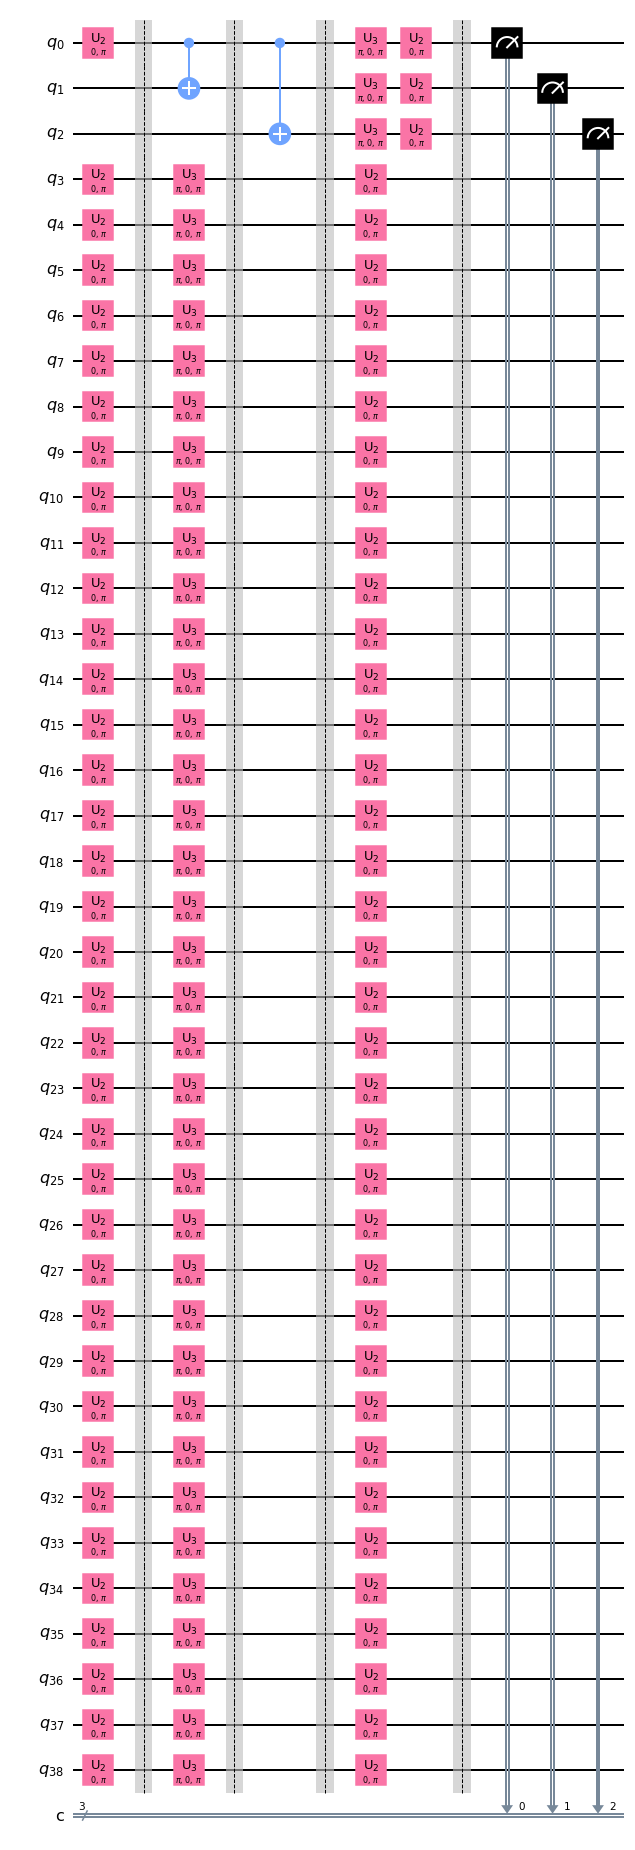

In [30]:
qcs_list[6].draw("mpl")

## Plot correlations

In [44]:
max_size = 15

In [45]:
# theoretical bounds
c_bounds = [2 * i for i in range(max_size)]
q_bounds = [2 * np.sqrt(2) * i for i in range(max_size)]

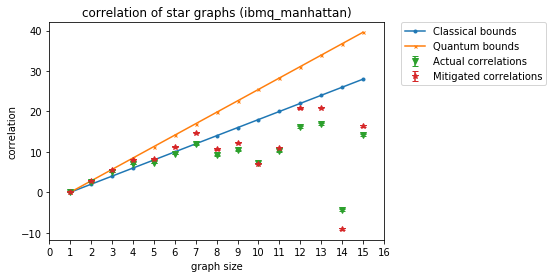

In [46]:
plt.clf()
plt.plot(list(range(1, max_size + 1)), c_bounds, label="Classical bounds", marker="o", markersize=3)
plt.plot(list(range(1, max_size + 1)), q_bounds, label="Quantum bounds", marker="x", markersize=3)
plt.errorbar(list(range(1, max_size + 1)), corr_list_real[:max_size], label="Actual correlations", fmt="v", yerr=stddev_list_real[:max_size], capsize=3)
plt.errorbar(list(range(1, max_size + 1)), tensored_corr_list_real[:max_size], label="Mitigated correlations", fmt="*", yerr=tensored_stddev_list_real[:max_size], capsize=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2)))
plt.title("correlation of star graphs (ibmq_manhattan)")
plt.show()

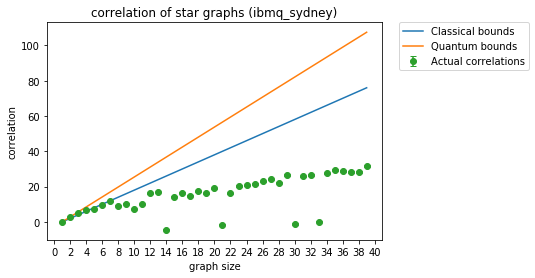

In [58]:
max_size = 39
# theoretical bounds
c_bounds = [2 * i for i in range(max_size)]
q_bounds = [2 * np.sqrt(2) * i for i in range(max_size)]
plt.clf()
plt.plot(list(range(1, max_size + 1)), c_bounds, label="Classical bounds") # , marker="o", markersize=3)
plt.plot(list(range(1, max_size + 1)), q_bounds, label="Quantum bounds") # , marker="x", markersize=3)
plt.errorbar(list(range(1, max_size + 1)), corr_list_real, label="Actual correlations", fmt="o", yerr=stddev_list_real, capsize=3)
# plt.errorbar(list(range(1, max_size + 1)), tensored_corr_list_real, label="Mitigated correlations", fmt="*", yerr=tensored_stddev_list_real, capsize=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2))[::2])
plt.title("correlation of star graphs (ibmq_sydney)")
plt.show()

In [48]:
each_corr_list = [[0]] + [E_1 + Es_2 for E_1, Es_2 in Es_list_real[1:]]
tp_each_corr_list = []
for i in range(len(each_corr_list)):
    tp_each_corr_list.append([each_corr_list[j][i] for j in range(i, len(each_corr_list))])
# pprint.pprint(tp_each_corr_list)

In [49]:
each_stddev_list = [[0]] + [D_1 + Ds_2 for D_1, Ds_2 in Ds_list_real[1:]]
tp_each_stddev_list = []
for i in range(len(each_stddev_list)):
    tp_each_stddev_list.append([each_stddev_list[j][i] for j in range(i, len(each_stddev_list))])
# pprint.pprint(tp_each_corr_list)

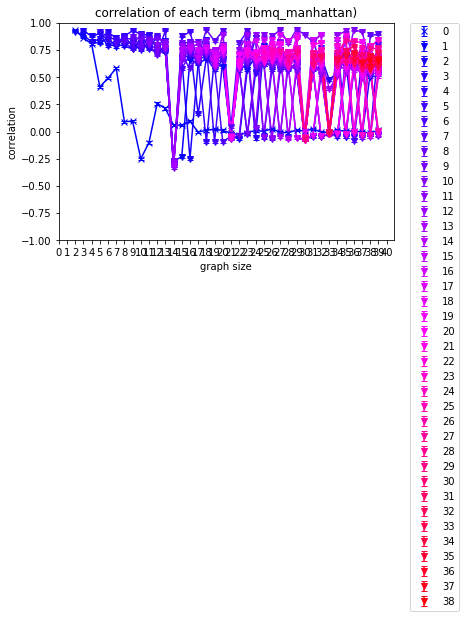

In [50]:
max_size = 39
plt.clf()
for i, (each_corr, each_stddev) in enumerate(zip(tp_each_corr_list, tp_each_stddev_list)):
    if i == 0:
        plt.plot(list(range(2, max_size + 1)), each_corr[1:], color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(2, max_size + 1)), each_corr[1:], label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="x", yerr=each_stddev[1:], capsize=3)
    else:
        plt.plot(list(range(i+1, max_size + 1)), each_corr, color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(i+1, max_size + 1)), each_corr, label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="v", yerr=each_stddev, capsize=3)
#  plt.plot(list(range(1, max_size + 1)), damped_vibration, label="damped vibration", color=[0, 0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2)))
plt.ylim([-1,1])
plt.title("correlation of each term (ibmq_manhattan)")
plt.show()

In [51]:
mitigated_each_corr_list = [[0]] + [E_1 + Es_2 for E_1, Es_2 in tensored_Es_list_real[1:]]
mitigated_tp_each_corr_list = []
for i in range(len(mitigated_each_corr_list)):
    mitigated_tp_each_corr_list.append([mitigated_each_corr_list[j][i] for j in range(i, len(mitigated_each_corr_list))])
# pprint.pprint(tp_each_corr_list)

In [52]:
mitigated_each_stddev_list = [[0]] + [D_1 + Ds_2 for D_1, Ds_2 in tensored_Ds_list_real[1:]]
mitigated_tp_each_stddev_list = []
for i in range(len(mitigated_each_stddev_list)):
    mitigated_tp_each_stddev_list.append([mitigated_each_stddev_list[j][i] for j in range(i, len(mitigated_each_stddev_list))])
# pprint.pprint(tp_each_corr_list)

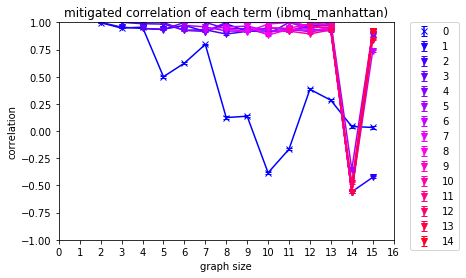

In [53]:
max_size = 15
plt.clf()
for i, (each_corr, each_stddev) in enumerate(zip(mitigated_tp_each_corr_list, mitigated_tp_each_stddev_list)):
    if i == 0:
        plt.plot(list(range(2, max_size + 1)), each_corr[1:], color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(2, max_size + 1)), each_corr[1:], label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="x", yerr=each_stddev[1:], capsize=3)
    else:
        plt.plot(list(range(i+1, max_size + 1)), each_corr, color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(i+1, max_size + 1)), each_corr, label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="v", yerr=each_stddev, capsize=3)
#  plt.plot(list(range(1, max_size + 1)), damped_vibration, label="damped vibration", color=[0, 0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2)))
plt.ylim([-1,1])
plt.title("mitigated correlation of each term (ibmq_manhattan)")
plt.show()

In [ ]:
max_size = 11
plt.clf()
for i, (each_corr, each_stddev) in enumerate(zip(mitigated_tp_each_corr_list, mitigated_tp_each_stddev_list)):
    if i == 0:
        plt.plot(list(range(2, max_size + 1)), each_corr[1:], color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(2, max_size + 1)), each_corr[1:], label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="x", yerr=each_stddev[1:], capsize=3)
    else:
        plt.plot(list(range(i+1, max_size + 1)), each_corr, color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(i+1, max_size + 1)), each_corr, label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="v", yerr=each_stddev, capsize=3)
#  plt.plot(list(range(1, max_size + 1)), damped_vibration, label="damped vibration", color=[0, 0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2)))
plt.ylim([-1,1.1])
plt.title("mitigated correlation of each term (ibmq_manhattan)")
plt.show()